In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings, os, re, nltk, string
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, RFECV, RFE, VarianceThreshold
warnings.filterwarnings('ignore')
import sklearn
sklearn.__version__

'1.5.2'

In [2]:
df = pd.read_csv('customer_booking.csv', encoding = "ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


## Informations
To provide more context, below is a more detailed data description, explaining exactly what each column means:

num_passengers (nombre de passagers) : C'est le nombre de passagers qui voyagent lors de la réservation.

sales_channel (canal de vente) : Le canal de vente où la réservation a été effectuée (par exemple, site web, agence de voyage).

trip_type (type de voyage) : Le type de voyage, comme un voyage aller-retour, un aller simple ou un voyage circulaire.

purchase_lead (délai d'achat) : Le nombre de jours entre la date de voyage et la date de réservation.

length_of_stay (durée du séjour) : Le nombre de jours passés à destination.

flight_hour (heure du vol) : L'heure à laquelle le vol décolle.

flight_day (jour du vol) : Le jour de la semaine où le vol décolle.

route (itinéraire) : Le trajet du vol, de l'origine à la destination (par exemple, Paris -> Londres).

booking_origin (origine de la réservation) : Le pays depuis lequel la réservation a été effectuée.

wants_extra_baggage (souhaite des bagages supplémentaires) : Indique si le client a voulu ajouter des bagages supplémentaires à la réservation.

wants_preferred_seat (souhaite un siège préféré) : Indique si le client a demandé un siège préféré lors de la réservation.

wants_in_flight_meals (souhaite des repas à bord) : Indique si le client a demandé des repas pendant le vol.

flight_duration (durée du vol) : La durée totale du vol en heures.

booking_complete (réservation complète) : Un indicateur pour savoir si le client a finalisé la réservation ou non.

In [3]:
df.sample(5)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
30788,1,Mobile,RoundTrip,335,4,20,Sat,DMKKIX,Thailand,0,0,0,7.00,0
39153,1,Internet,RoundTrip,240,5,2,Fri,ICNMEL,South Korea,1,1,1,8.83,0
45150,2,Internet,RoundTrip,62,6,14,Sun,DPSICN,South Korea,1,0,1,6.62,0
28609,1,Internet,RoundTrip,58,3,12,Sat,MAAMEL,Australia,0,0,0,8.83,0
27020,1,Internet,RoundTrip,24,3,15,Thu,DELMFM,India,1,0,1,5.52,0


In [4]:
df.describe().T, df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

(                         count       mean        std   min    25%    50%  \
 num_passengers         50000.0   1.591240   1.020165  1.00   1.00   1.00   
 purchase_lead          50000.0  84.940480  90.451378  0.00  21.00  51.00   
 length_of_stay         50000.0  23.044560  33.887670  0.00   5.00  17.00   
 flight_hour            50000.0   9.066340   5.412660  0.00   5.00   9.00   
 wants_extra_baggage    50000.0   0.668780   0.470657  0.00   0.00   1.00   
 wants_preferred_seat   50000.0   0.296960   0.456923  0.00   0.00   0.00   
 wants_in_flight_meals  50000.0   0.427140   0.494668  0.00   0.00   0.00   
 flight_duration        50000.0   7.277561   1.496863  4.67   5.62   7.57   
 booking_complete       50000.0   0.149560   0.356643  0.00   0.00   0.00   
 
                           75%    max  
 num_passengers           2.00    9.0  
 purchase_lead          115.00  867.0  
 length_of_stay          28.00  778.0  
 flight_hour             13.00   23.0  
 wants_extra_baggage      1.

<AxesSubplot:ylabel='count'>

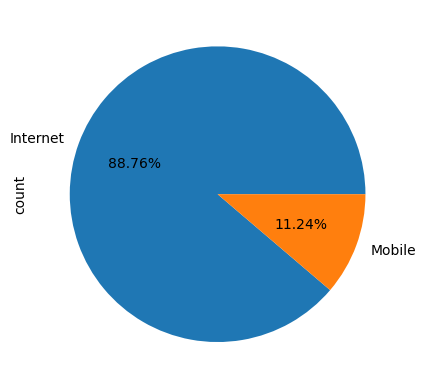

In [5]:
df.sales_channel.value_counts().plot(kind = 'pie', autopct = '%.2f%%')

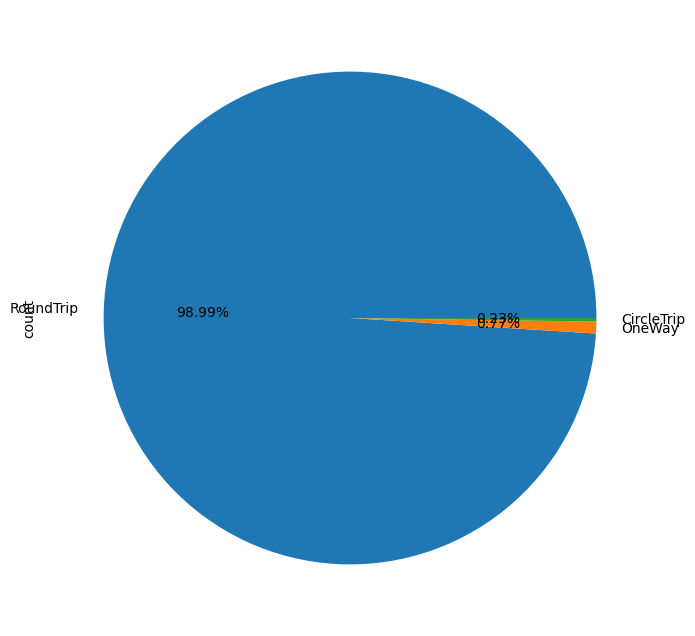

In [6]:
### type de voyage
plt.figure(figsize=(12, 8))
df.trip_type.value_counts().plot(kind = 'pie', autopct = '%.2f%%')
plt.show()

In [7]:
df.booking_complete.value_counts().reset_index(drop = False)

,booking_complete,count
0,0,42522
1,1,7478


num_passengers


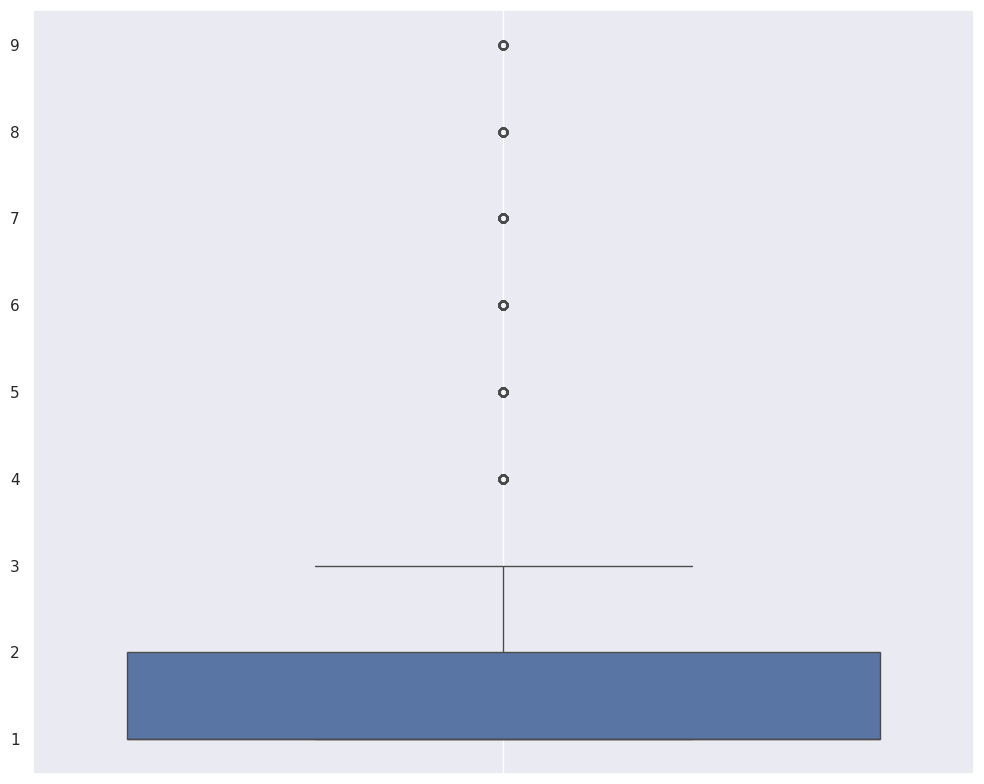

purchase_lead


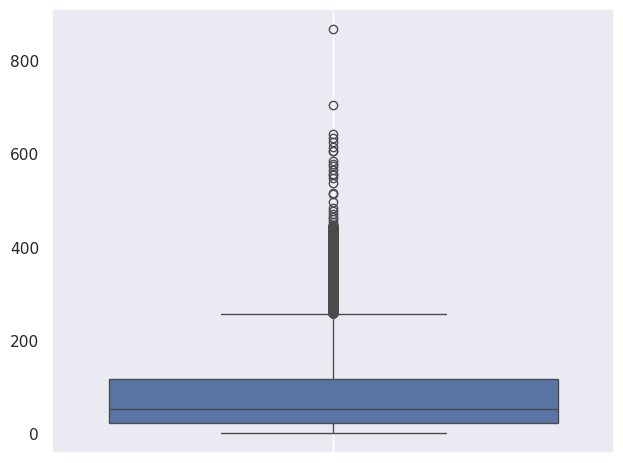

length_of_stay


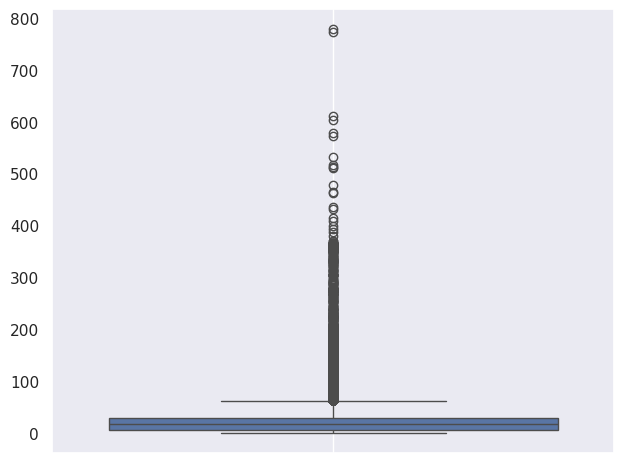

flight_hour


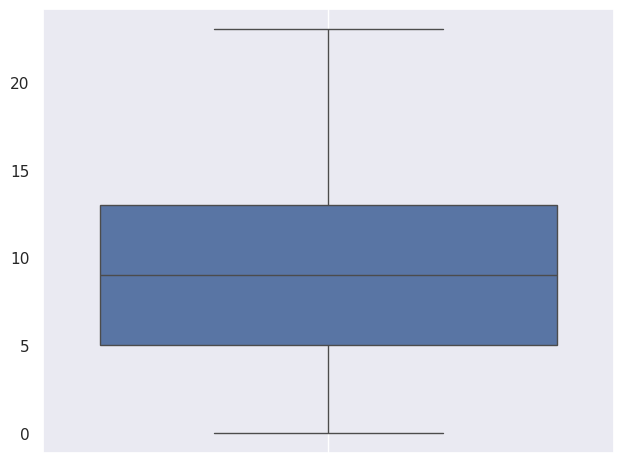

wants_extra_baggage


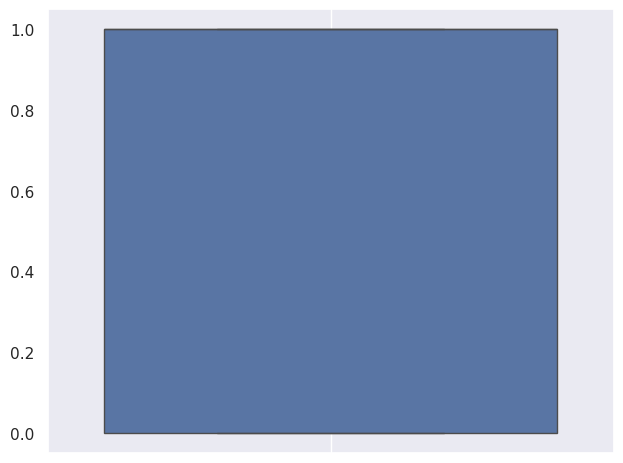

wants_preferred_seat


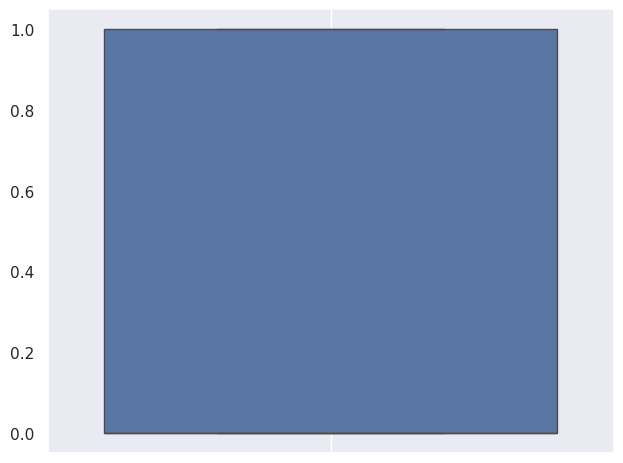

wants_in_flight_meals


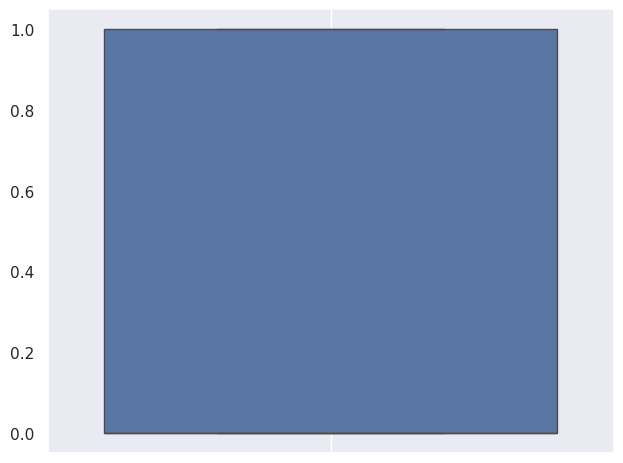

flight_duration


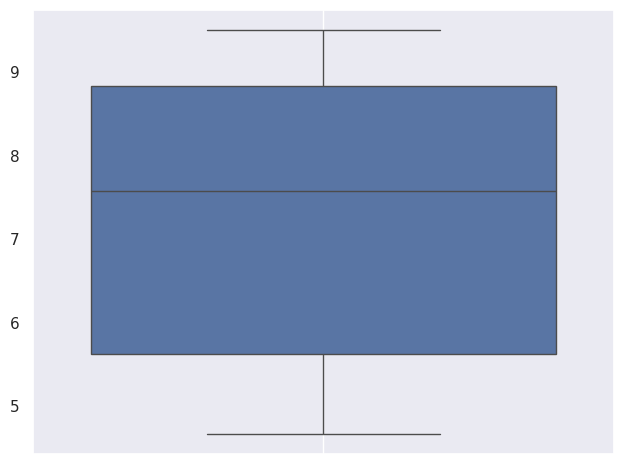

In [8]:
num_cols = ['num_passengers', 'purchase_lead','length_of_stay', 
          'flight_hour', 'wants_extra_baggage', 'wants_preferred_seat',
           'wants_in_flight_meals', 'flight_duration']
sns.set()
plt.figure(figsize=(10, 8))
for col in num_cols:
    print(f"{col}")
    data_col= np.array(df[col])
    sns.boxplot(data = data_col)
    plt.tight_layout(pad=1.08, h_pad=1)
    plt.grid()
    plt.show()

num_passengers


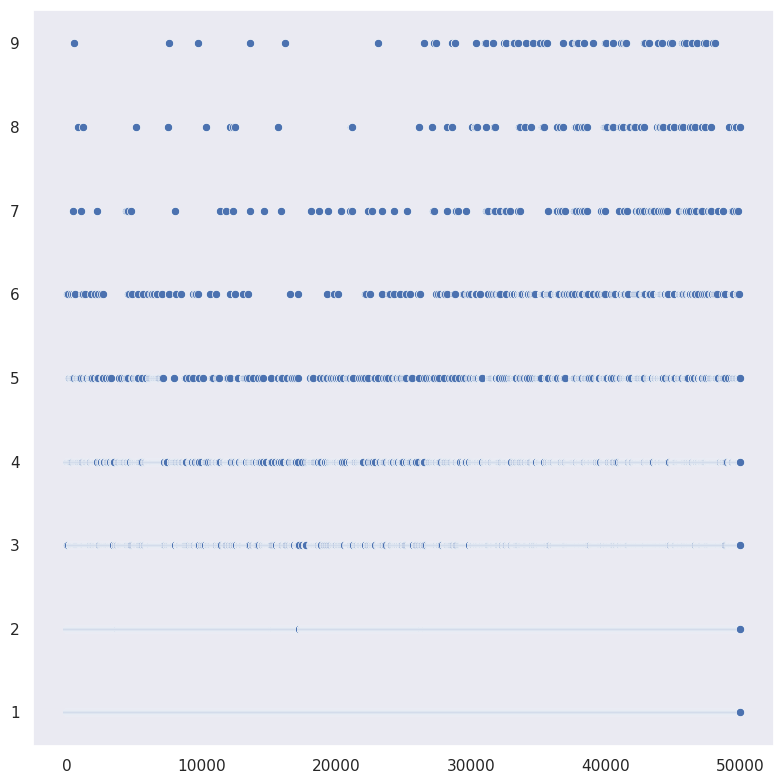

purchase_lead


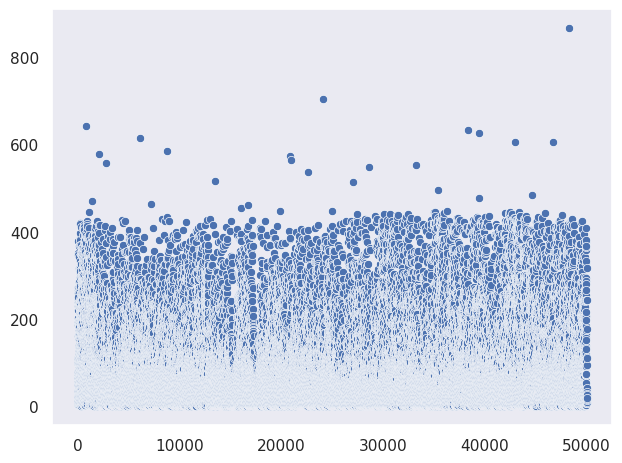

length_of_stay


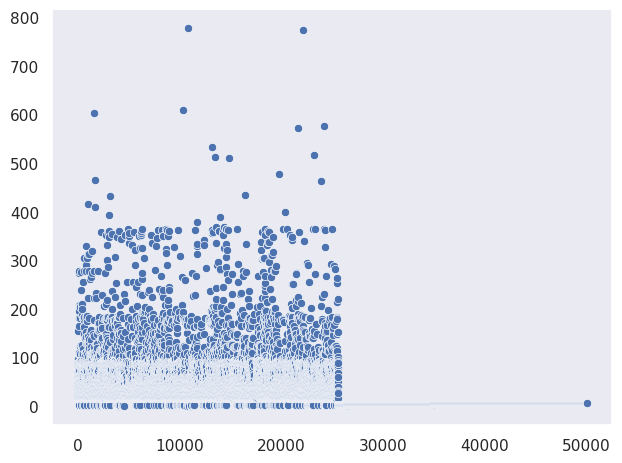

flight_hour


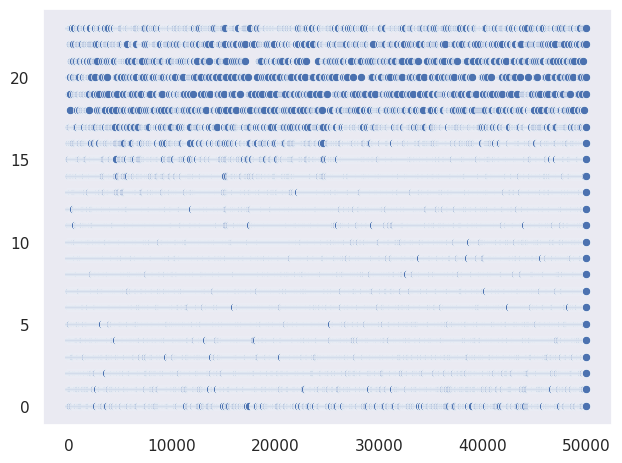

wants_extra_baggage


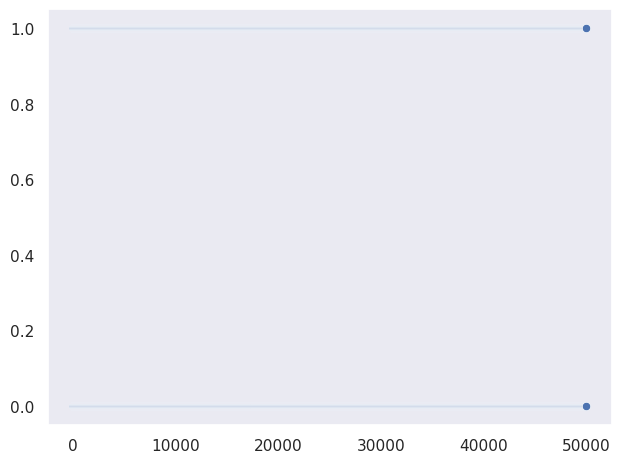

wants_preferred_seat


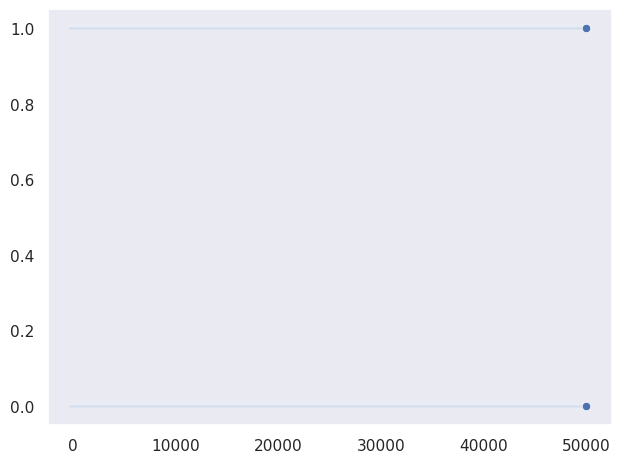

wants_in_flight_meals


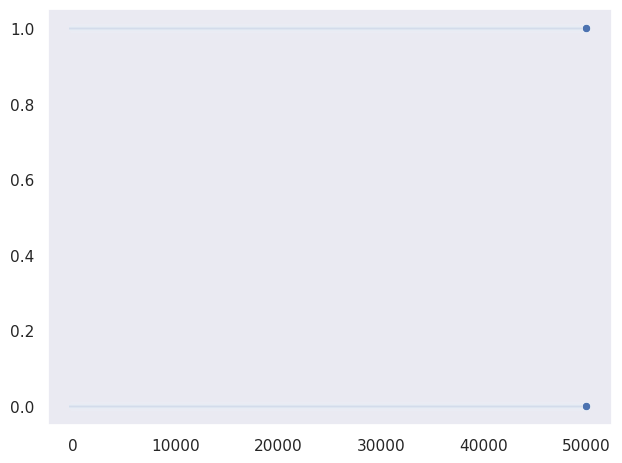

flight_duration


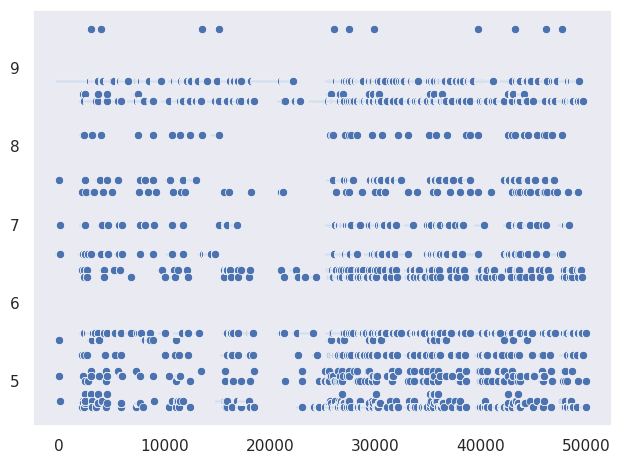

In [9]:
sns.set()
plt.figure(figsize=(8, 8))
for col in num_cols:
    print(f"{col}")
    data_col = np.array(df[col])
    sns.scatterplot(data = data_col)
    plt.tight_layout(pad=1.08, h_pad=1)
    plt.grid()
    plt.show()

<AxesSubplot:>

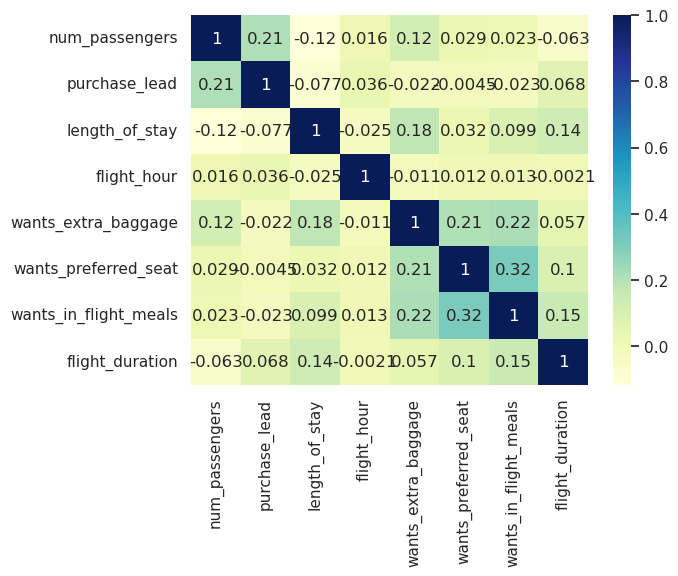

In [10]:
import missingno as msno

sns.heatmap(df[num_cols].corr(), annot = True, 
            cmap = 'YlGnBu')

## slection des variables avec la varince

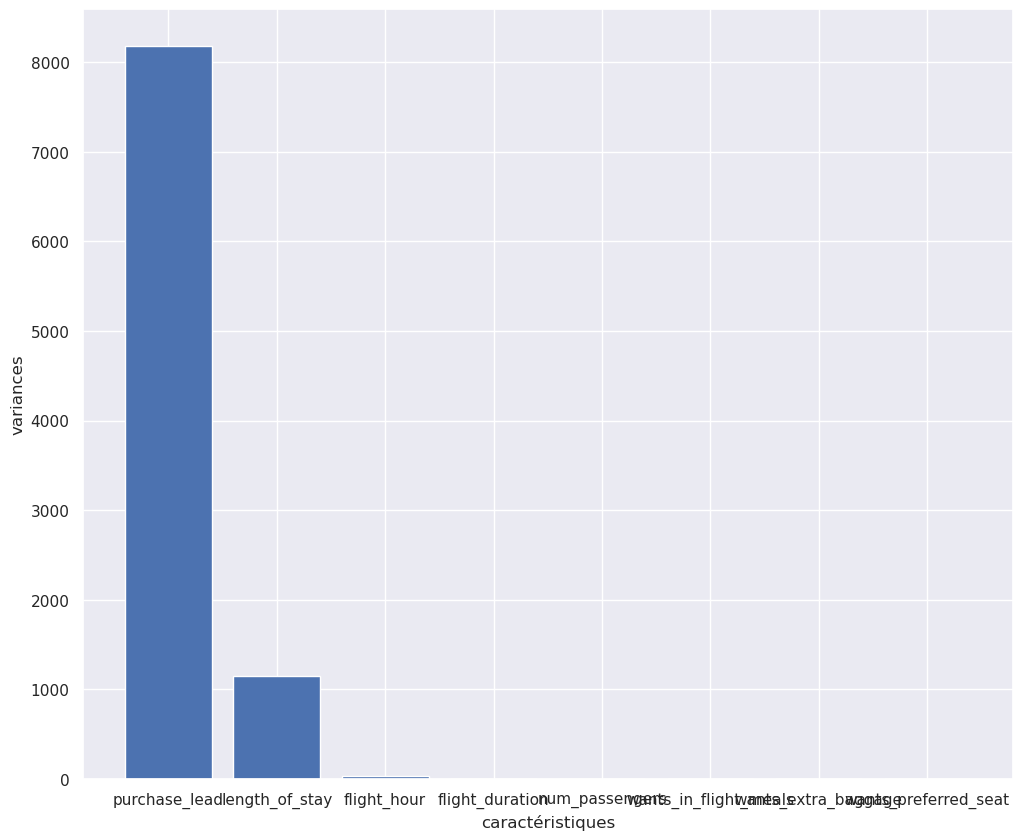

In [11]:
##### 
X = df[num_cols]

variances = np.var(X, axis = 0)
indices = np.argsort(variances)[::-1]
plt.figure(figsize=(12, 10))
plt.bar(x = X.columns[indices], height = variances[indices])
plt.xlabel('caractéristiques')
plt.ylabel('variances')
plt.show()

### selection des variables en se basant sur l'anova

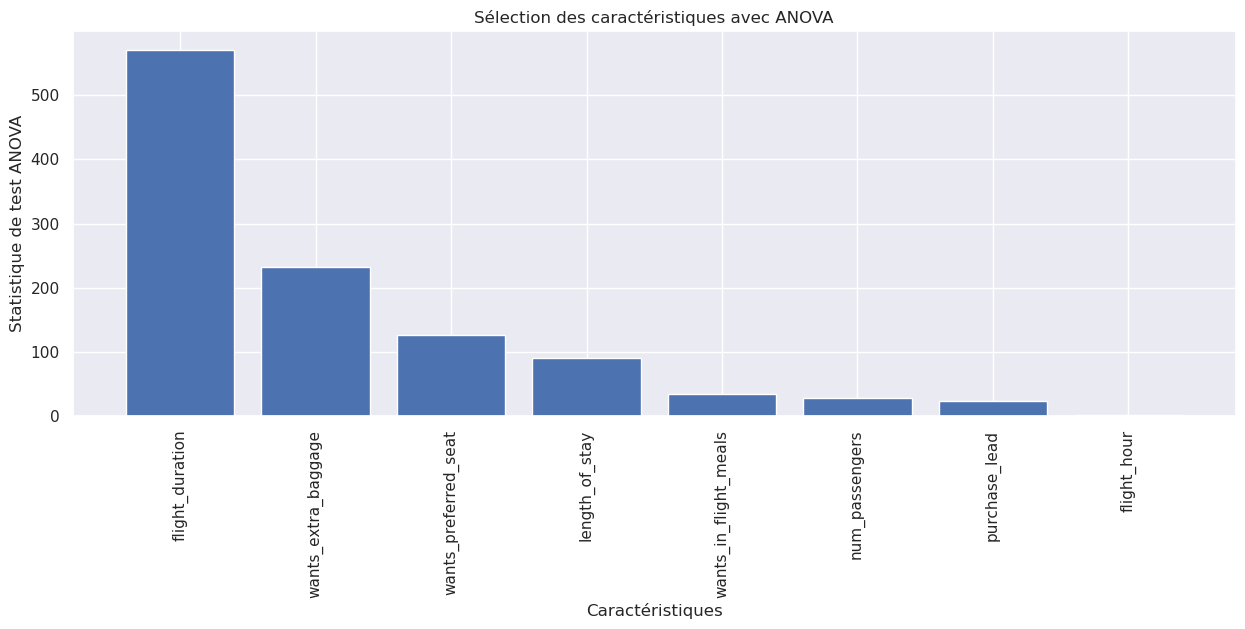

In [12]:
X= df[num_cols]
y = df['booking_complete']

# Appliquer la fonction SelectKBest avec ANOVA pour sélectionner les k meilleures caractéristiques
selector = SelectKBest(score_func=f_classif, k='all')
X_new = selector.fit_transform(X, y)
anova_scores = selector.scores_
sorted_indices = np.argsort(anova_scores)[::-1]

# Afficher la courbe des scores ANOVA
plt.figure(figsize=(15, 5))
plt.bar(x=X.columns[sorted_indices], height=anova_scores[sorted_indices])
plt.xticks(rotation=90)
plt.xlabel('Caractéristiques')
plt.ylabel('Statistique de test ANOVA')
plt.title('Sélection des caractéristiques avec ANOVA')
plt.show()

## Model basé sur la variance

In [13]:
maxi = 0.8 * (1 - 0.8)
selector = VarianceThreshold(threshold= maxi)
X_selector =selector.fit_transform(X)

selected_columns = X.columns[selector.get_support()]
print(f"Les caracterisntiques importantes", selected_columns)

Les caracterisntiques importantes Index(['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
       'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals',
       'flight_duration'],
      dtype='object')


In [14]:
df.sample(4)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
15913,1,Internet,RoundTrip,14,18,0,Thu,KBVOOL,Australia,0,0,1,8.83,0
3057,3,Internet,RoundTrip,6,86,6,Thu,BWNDEL,Brunei,1,0,1,5.52,0
6981,3,Internet,RoundTrip,284,29,6,Mon,COKSYD,Australia,1,1,0,8.58,0
25332,1,Internet,RoundTrip,35,33,5,Sun,SYDTPE,Taiwan,1,0,0,8.58,0


In [15]:
df.flight_day.value_counts()

flight_day
Mon    8102
Wed    7674
Tue    7673
Thu    7424
Fri    6761
Sun    6554
Sat    5812
Name: count, dtype: int64

In [16]:
df.route.value_counts().reset_index()

,route,count
0,AKLKUL,2680
1,PENTPE,924
2,MELSGN,842
3,ICNSIN,801
4,DMKKIX,744
...,...,...
794,LBUTPE,1
795,CXRMEL,1
796,DELKBR,1
797,KOSSYD,1


### ré"-echantillonnage des données 

la distribution n'est pas normale au niveau de la classe cible. Donc une technique de réechantillonnage peut
etre appliqué pour qu'on est les meme distributions 

### Random oversampling (sur echantilonnage )
### Random undersampling( sous-echantillonnage)
### SMOTE

In [17]:
### using smote
#smote = SMOTE(random_state=42, 
             #sampling_strategy='auto')
#df_smote = smote.fit_resample(df)
#df_smote.booking_complete.value_counts()

### Preprocessing of dataset

In [18]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [19]:
code_mapping = {
    'Internet' : 1,
    'Mobile': 0
}

code_trip = {
    'RoundTrip':0,
    'CircleTrip' :1,
    'OneWay': 2
    }

mapping_day={
    'Mon':1,
    'Tue':2,
    'Wed': 3,
    'Thu': 4,
    'Fri': 5,
    'Sat': 6,
    'Sun': 7
}


In [20]:
df.sample(5)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
31223,2,Internet,RoundTrip,16,4,1,Sun,DPSICN,South Korea,1,0,1,6.62,1
9669,1,Internet,RoundTrip,55,26,4,Mon,DMKOOL,Australia,1,0,0,8.83,0
36140,1,Internet,RoundTrip,38,5,4,Thu,CNXTPE,Taiwan,0,1,1,4.67,0
27058,2,Mobile,RoundTrip,18,3,0,Thu,DMKHND,Japan,0,0,0,7.57,0
22514,1,Internet,RoundTrip,85,120,8,Thu,PENPER,Australia,1,0,0,5.62,0


In [21]:
dff = df.copy()
dff['sales_channel'] = dff['sales_channel'].map(code_mapping)
dff['trip_type'] = dff['trip_type'].map(code_trip)
dff['flight_day'] = dff['flight_day'].map(mapping_day)

In [22]:
dff.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,1,0,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,1,0,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,1,0,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,1,0,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,1,0,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


In [23]:
dff.shape

(50000, 14)

In [24]:
dff.sample(4)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
34706,2,1,0,248,4,14,7,PUSSIN,Canada,1,0,0,6.33,0
622,1,1,0,73,39,11,6,AKLKUL,New Zealand,1,1,0,8.83,0
7721,1,0,0,19,19,12,5,DACMEL,Australia,0,0,0,8.83,0
20905,1,1,0,260,27,23,1,MELTRZ,Australia,1,0,1,8.83,0


In [25]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_cols = ['num_passengers', 'sales_channel', 'trip_type',
           'purchase_lead', 'length_of_stay', 'flight_hour',
           'flight_day', 'wants_extra_baggage', 'wants_preferred_seat', 
           'wants_in_flight_meals', 'flight_duration']

cat_cols = ['route', 'booking_origin']

pipeline_numeric = Pipeline(steps=[
    ('scaler', StandardScaler())
])

pipeline_cat = Pipeline(steps = [
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', pipeline_numeric, num_cols),
    ('cat', pipeline_cat, cat_cols)
])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['num_passengers', 'sales_channel',
                                  'trip_type', 'purchase_lead',
                                  'length_of_stay', 'flight_hour', 'flight_day',
                                  'wants_extra_baggage', 'wants_preferred_seat',
                                  'wants_in_flight_meals', 'flight_duration']),
                                ('cat',
                                 Pipeline(steps=[('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['route', 'booking_origin'])])

In [26]:
### test split
X = dff.drop('booking_complete', axis = 1)
y = dff['booking_complete']

X_train, X_test, y_train, y_test =train_test_split(
    X, y, test_size=0.2,
    random_state=42
)

### fittiing preprocessing
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)


## Baseline model(Logistic Regression)

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score, KFold,StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,f1_score, precision_score, roc_auc_score, roc_curve, recall_score

base_model = LogisticRegression(penalty='l2', C = 0.1)
base_model.fit(X_train_prep, y_train)
predicted = base_model.predict(X_test_prep)
print("Result")
print(f"accuracy {accuracy_score(y_test, predicted)}")

print()
cross = cross_val_score(base_model, X_train_prep, y_train, cv = 5)
print(classification_report(y_test, predicted))
print()

print("Average 5-Fold CV Score: {}".format(round(np.mean(cross),4)),
      "Standard deviation: {}".format(round(np.std(cross),4)))


Result
accuracy 0.8538

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      8520
           1       0.57      0.05      0.09      1480

    accuracy                           0.85     10000
   macro avg       0.72      0.52      0.50     10000
weighted avg       0.82      0.85      0.80     10000


Average 5-Fold CV Score: 0.8495 Standard deviation: 0.0017


In [28]:
predicted.shape

(10000,)

In [29]:
###Oversampling
df_majority = dff[dff.booking_complete == 0]
df_minority = dff[dff.booking_complete  == 1]

print(f"The value counts majority {df_majority.booking_complete.count()}")
print(f"The value counts minority {df_minority.booking_complete.count()}")
print(f"The value counts {df.booking_complete.count()}")

The value counts majority 42522
The value counts minority 7478
The value counts 50000


### Modeling avec Rechantillonnage Over

In [30]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

## overresampling data
df_minority_over = resample(df_minority, 
                            replace= True,
                            n_samples= 42522, 
                            random_state=42)
df_over = pd.concat([df_majority, df_minority_over])
df_over.booking_complete.value_counts()

booking_complete
0    42522
1    42522
Name: count, dtype: int64

In [31]:
### undersampling

df_majority_over =resample(df_majority,
                           replace= True,
                           n_samples = 7478,
                           random_state=42)
df_under = pd.concat([df_majority_over, df_minority])
df_under.booking_complete.value_counts()

booking_complete
0    7478
1    7478
Name: count, dtype: int64

### Result model avec Mormal dataset

In [32]:
X_test_prep.shape, y_test.shape, X_train_prep.shape

((10000, 886), (10000,), (40000, 886))

### Hyparameters Tuning

### Result avec Oversampling

In [33]:
from sklearn.metrics import f1_score

X_over= df_over.drop('booking_complete', axis = 1)
y_over = df_over.booking_complete

Xtrain, Xtest, ytrain, ytest = train_test_split(X_over, y_over, test_size=0.2, stratify=y_over,
                                                random_state=42)
Xtrain_pre = preprocessor.fit_transform(Xtrain)
Xtest_pre = preprocessor.transform(Xtest)
estimators = [
    ('EXTRAAA', ExtraTreesClassifier()),
    ('Bagging', BaggingClassifier(max_samples = 1.0, n_estimators = 10))
]
for model_name, estimator in estimators:
    print(""" Test Result """)
    print()
    print(f"Name_model :{model_name}")
    estimator.fit(Xtrain_pre, ytrain)
    pred = estimator.predict(Xtest_pre)
    print()
    print(f"Accuracy: {accuracy_score(ytest, pred)}")
    print()
    print(f"Precision: {precision_score(ytest, pred)}")
    print()
    print(f"F1_score: {f1_score(ytest, pred)}")

 Test Result 

Name_model :EXTRAAA

Accuracy: 0.966664706919866

Precision: 0.9419757211270743

F1_score: 0.967568495109535
 Test Result 

Name_model :Bagging

Accuracy: 0.9393262390499147

Precision: 0.8974468085106383

F1_score: 0.9423592493297587


In [34]:
### test split
X = dff.drop('booking_complete', axis = 1)
y = dff['booking_complete']

X_train, X_test, y_train, y_test =train_test_split(
    X, y, test_size=0.2,
    random_state=42
)

### fittiing preprocessing
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

estimators = [
    ('EXTRAAA', ExtraTreesClassifier()),
    ('Bagging', BaggingClassifier(max_samples = 1.0, n_estimators = 10))
]
for model_name, estimator in estimators:
    print(""" Test Result """)
    print()
    print(f"Name model: {model_name}")
    estimator.fit(X_train_prep, y_train)
    predicted = estimator.predict(X_test_prep)
    print()
    print(f"Accuracy: {accuracy_score(y_test, predicted)}")
    print()
    print(f"Precision: {precision_score(y_test, predicted)}")
    print()
    print(f"F1_score: {f1_score(y_test, predicted)}")

 Test Result 

Name model: EXTRAAA

Accuracy: 0.8457

Precision: 0.4534711964549483

F1_score: 0.28465461288827076
 Test Result 

Name model: Bagging

Accuracy: 0.8475

Precision: 0.4617996604414261

F1_score: 0.26292895118414694


### Best model Final

In [35]:
best_model = BaggingClassifier(
    max_samples = 1.0, 
    n_estimators = 10)

best_model.fit(Xtrain_pre, ytrain)
predited = best_model.predict(Xtest_pre)
print(best_model)
print()
print(f"Accuracy: {accuracy_score(ytest, predited)}")
print()
print(f"Precision: {precision_score(ytest, predited)}")
print()
print(f"F1_score: {f1_score(ytest, predited)}")
print()

print(f"Sucess !")

BaggingClassifier()

Accuracy: 0.9373860897172085

Precision: 0.8952289873552226

F1_score: 0.9405526095450739

Sucess !


In [36]:
### Features importances 

def plot_Feature(feature, clf):
    tmp = pd.DataFrame({'Feature': feature, 
                        'Feature importance': clf.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False)
    fig = go.Figure(go.Bar(
    x=tmp['Feature'],y=tmp['Feature importance'],marker={'color': tmp['Feature importance'], 
    'colorscale': 'Viridis'}
    ))
    fig.update_layout(title_text='Feature Importance',xaxis_title="Feature",yaxis_title="Importance")
    return fig.show()

In [37]:
best_estimator = ExtraTreesClassifier()

best_estimator.fit(Xtrain_pre, ytrain)
predited = best_estimator.predict(Xtest_pre)
print(best_estimator)
print()
print(f"Accuracy: {accuracy_score(ytest, predited)}")
print()
print(f"Precision: {precision_score(ytest, predited)}")
print()
print(f"F1_score: {f1_score(ytest, predited)}")
print()

print(f"Sucess !")

ExtraTreesClassifier()

Accuracy: 0.9677817625962726

Precision: 0.9436761097479367

F1_score: 0.9686319404693761

Sucess !


In [38]:
preprocessor.get_feature_names_out()

array(['num__num_passengers', 'num__sales_channel', 'num__trip_type',
       'num__purchase_lead', 'num__length_of_stay', 'num__flight_hour',
       'num__flight_day', 'num__wants_extra_baggage',
       'num__wants_preferred_seat', 'num__wants_in_flight_meals',
       'num__flight_duration', 'cat__route_AKLDEL', 'cat__route_AKLHGH',
       'cat__route_AKLHND', 'cat__route_AKLICN', 'cat__route_AKLKIX',
       'cat__route_AKLKTM', 'cat__route_AKLKUL', 'cat__route_AKLMRU',
       'cat__route_AKLPEK', 'cat__route_AKLPVG', 'cat__route_AKLTPE',
       'cat__route_AORICN', 'cat__route_AORKIX', 'cat__route_AORKTM',
       'cat__route_AORMEL', 'cat__route_AORPER', 'cat__route_AORPUS',
       'cat__route_BBIMEL', 'cat__route_BBIOOL', 'cat__route_BBISYD',
       'cat__route_BDOCTS', 'cat__route_BDOCTU', 'cat__route_BDOHGH',
       'cat__route_BDOICN', 'cat__route_BDOIKA', 'cat__route_BDOKIX',
       'cat__route_BDOMEL', 'cat__route_BDOOOL', 'cat__route_BDOPEK',
       'cat__route_BDOPER', 'cat__r

In [39]:
import joblib

# Chemin pour sauvegarder le modèle
filename = "/home/einstein/Projects Data Science/British_vol/backend/model_vol/model_bagging.pkl"

# Sauvegarder le modèle dans un fichier
joblib.dump(best_model, filename)

print(f"Modèle sauvegardé sous : {filename}")


Modèle sauvegardé sous : /home/einstein/Projects Data Science/British_vol/backend/model_vol/model_bagging.pkl


In [40]:
len(best_estimator.feature_importances_), Xtrain_pre.shape

(907, (68035, 907))

In [45]:
filename = "/home/einstein/Projects Data Science/British_vol/backend/model_vol/pipeline_model_bagging.joblib"

pipeline_model = Pipeline(steps = [('preprocessor', preprocessor), ('model', best_model)])
# Sauvegarder le modèle dans un fichier
joblib.dump(pipeline_model, filename)

print(f"Modèle sauvegardé sous : {filename}")


Modèle sauvegardé sous : /home/einstein/Projects Data Science/British_vol/backend/model_vol/pipeline_model_bagging.joblib
